In [4]:
import os
import sys
from vault_client.instances import Production as VaultClient
client = VaultClient(authorization=f"OAuth {os.environ['YAV_TOKEN']}", decode_files=True)
secrets = client.get_version('sec-01ct0ebtvcs99z0gns9ecg0159')

In [3]:
from clan_tools import utils
from clan_tools.data_adapters.YQLAdapter import YQLAdapter
from clan_tools.logging.logger import default_log_config
from clan_tools.utils.timing import timing
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import statsmodels.api as sm
from scipy import stats
from scipy.special import inv_boxcox
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

yql_adapter = YQLAdapter()

KeyError: 'YQL_TOKEN'

In [3]:
query = """
    $disks_max_for_1cid_in_1h_target = (
        select
            `date` as rep_date,
            `hour` as rep_time,
            disk_id,
            If(disk_type like '%hdd%', 'hdd', 'ssd') as disk_type_sh,
            Cast(Max(disk_size) as double)/1024/1024/1024 as disk_size_GB
        from range(`home/cloud_analytics/dwh/ods/compute/disks`, `2020-07-02`, `2021-04-12`)
        group by `date`, `hour`, disk_id, disk_type
    );

    $disks_max_size_in_1h_target = (
        select
            rep_date,
            rep_time,
            disk_type_sh,
            Sum(disk_size_GB) as disk_size_GB
        from $disks_max_for_1cid_in_1h_target
        group by rep_date, rep_time, disk_type_sh
    );

    $disks_1d_target = (
        select
            rep_date,
            disk_type_sh,
            Max(disk_size_GB) as disk_size_GB
        from $disks_max_size_in_1h_target
        group by rep_date, disk_type_sh
    );

    $disks_granular_to_ba_1h_features = (
        select 
            `date` as rep_date,
            `hour` as rep_time,
            If(disk_type like '%hdd%', 'hdd', 'ssd') as disk_type_sh,
            billing_account_id,
            billing_account_state,
            billing_account_status,
            CountDistinctEstimate(cloud_id) as cid_cnt
        from range(`home/cloud_analytics/dwh/ods/compute/disks`, `2020-07-02`, `2021-04-12`)
        group by `date`, `hour`, disk_type, billing_account_id, billing_account_state, billing_account_status
    );

    $disks_1h_features = (
        select
            rep_date,
            rep_time,
            disk_type_sh,
            Cast(CountDistinctEstimate(billing_account_id) as double) as ba_total_cnt,
            Cast(Count_If(billing_account_state == 'active') as double) as ba_act_cnt,
            Cast(Count_If(billing_account_state == 'payment_required') as double) as ba_preq_cnt,
            Cast(Count_If(billing_account_state == 'suspended') as double) as ba_susp_cnt,
            Cast(Count_If(billing_account_status == 'paid') as double) as ba_paid_cnt,
            Cast(Count_If(billing_account_status == 'trial') as double) as ba_trial_cnt,
            Cast(Count_If(billing_account_status == 'service') as double) as ba_serv_cnt,
            Cast(Count_If(cid_cnt == 1) as double) as ba_cid_eq_1,
            Cast(Count_If((cid_cnt>=2) and (cid_cnt<=5)) as double) as ba_cid_2_to_5,
            Cast(Count_If((cid_cnt>=6) and (cid_cnt<=10)) as double) as ba_cid_gr_5,
            Cast(Sum(cid_cnt) as double) as cid_total_cnt
        from $disks_granular_to_ba_1h_features
        group by rep_date, rep_time, disk_type_sh
    );

    $disks_1d_features = (
        select 
            rep_date,
            disk_type_sh,
            Avg(ba_total_cnt) as ba_total_cnt_avg,
            Median(ba_total_cnt) as ba_total_cnt_median,
            Avg(ba_act_cnt) as ba_act_cnt_avg,
            Median(ba_act_cnt) as ba_act_cnt_median,
            Avg(ba_preq_cnt) as ba_preq_cnt_avg,
            Median(ba_preq_cnt) as ba_preq_cnt_median,
            Avg(ba_susp_cnt) as ba_susp_cnt_avg,
            Median(ba_susp_cnt) as ba_susp_cnt_median,
            Avg(ba_paid_cnt) as ba_paid_cnt_avg,
            Median(ba_paid_cnt) as ba_paid_cnt_median,
            Avg(ba_trial_cnt) as ba_trial_cnt_avg,
            Median(ba_trial_cnt) as ba_trial_cnt_median,
            Avg(ba_serv_cnt) as ba_serv_cnt_avg,
            Median(ba_serv_cnt) as ba_serv_cnt_median,
            Avg(ba_cid_eq_1) as ba_cid_eq_1_avg,
            Median(ba_cid_eq_1) as ba_cid_eq_1_median,
            Avg(ba_cid_2_to_5) as ba_cid_2_to_5_avg,
            Median(ba_cid_2_to_5) as ba_cid_2_to_5_median,
            Avg(ba_cid_gr_5) as ba_cid_gr_5_avg,
            Median(ba_cid_gr_5) as ba_cid_gr_5_median,
            Avg(cid_total_cnt) as cid_total_cnt_avg,
            Median(cid_total_cnt) as cid_total_cnt_median
        from $disks_1h_features
        group by rep_date, disk_type_sh
    );

    select 
        trg.disk_size_GB,
        ftr.*
    from $disks_1d_target as trg
        left join $disks_1d_features as ftr 
            on (trg.rep_date == ftr.rep_date) and (trg.disk_type_sh == ftr.disk_type_sh)
    ;
"""

In [4]:
if 'tmp.csv' in os.listdir('//home/pavelvasilev'):
    df = pd.read_csv('//home/pavelvasilev/tmp.csv')
else:
    df = yql_adapter.execute_query(query, to_pandas=True)
    df.to_csv('//home/pavelvasilev/tmp.csv', index=None)

In [5]:
print(df.shape)
df['rep_date'] = pd.to_datetime(df['rep_date'])
df.head()

(570, 25)


,ba_act_cnt_avg,ba_act_cnt_median,ba_cid_2_to_5_avg,ba_cid_2_to_5_median,ba_cid_eq_1_avg,ba_cid_eq_1_median,ba_cid_gr_5_avg,ba_cid_gr_5_median,ba_paid_cnt_avg,ba_paid_cnt_median,...,ba_susp_cnt_median,ba_total_cnt_avg,ba_total_cnt_median,ba_trial_cnt_avg,ba_trial_cnt_median,cid_total_cnt_avg,cid_total_cnt_median,disk_type_sh,rep_date,trg.disk_size_GB
0,4026.125000,4017.5,108.125000,108.0,7110.416667,7118.5,0.0,0.0,3928.958333,3927.0,...,2554.0,7307.416667,7317.5,3286.583333,3298.0,7439.458333,7447.5,hdd,2020-07-02,2.167869e+06
1,4132.833333,4131.0,109.000000,109.0,7113.208333,7109.5,0.0,0.0,3922.375000,3923.0,...,2523.5,7309.208333,7305.5,3296.833333,3293.0,7445.375000,7442.5,hdd,2020-07-03,2.154826e+06
2,4180.000000,4176.0,109.000000,109.0,7114.666667,7118.0,0.0,0.0,3924.583333,3925.0,...,2511.5,7307.208333,7311.5,3296.083333,3300.0,7446.666667,7449.0,hdd,2020-07-04,2.158561e+06
3,4182.250000,4180.0,108.875000,109.0,7121.541667,7121.5,0.0,0.0,3922.791667,3923.0,...,2519.0,7312.416667,7310.5,3304.625000,3305.5,7453.458333,7452.0,hdd,2020-07-05,2.165321e+06
4,4197.666667,4197.5,110.833333,111.0,7133.791667,7133.0,0.0,0.0,3934.958333,3934.0,...,2538.5,7321.750000,7320.5,3306.666667,3306.0,7469.250000,7468.5,hdd,2020-07-06,2.167468e+06


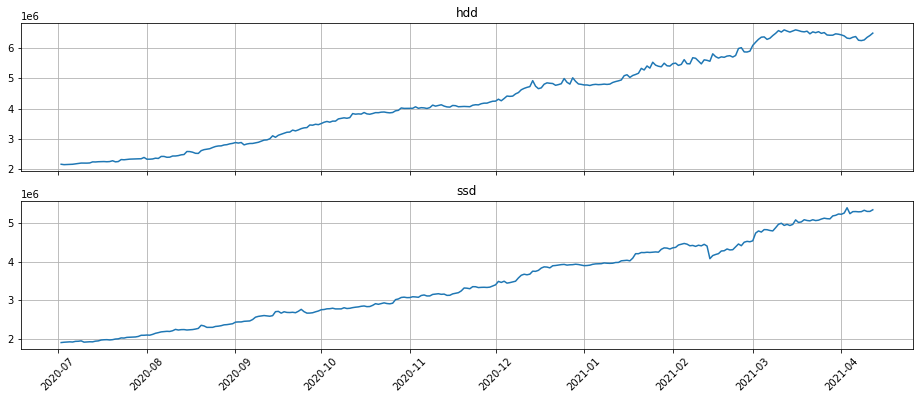

In [6]:
plt.subplots(2,1,sharex=True,figsize=(16,6))
ax = plt.subplot(2,1,1)
plt.title('hdd')
tmp = df[df['disk_type_sh']=='hdd']
plt.plot(tmp['rep_date'],tmp['trg.disk_size_GB'])
plt.grid()
ax = plt.subplot(2,1,2)
plt.title('ssd')
tmp = df[df['disk_type_sh']=='ssd']
plt.plot(tmp['rep_date'],tmp['trg.disk_size_GB'])
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Sarimax (HDD)

### Data split

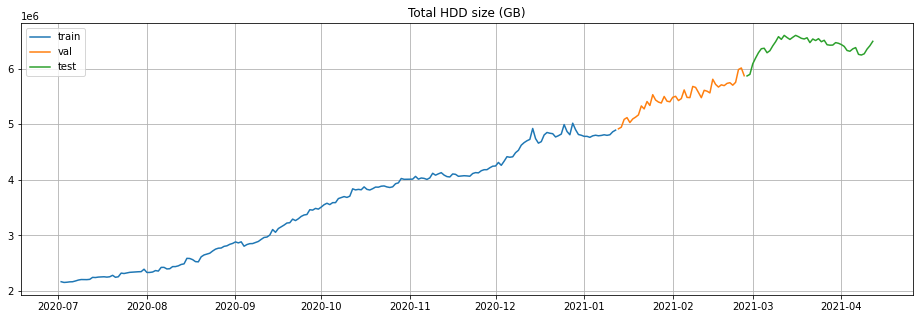

In [7]:
df_ts_hdd = df[df['disk_type_sh']=='hdd'].set_index('rep_date')[['trg.disk_size_GB']]
df_ts_hdd.columns = ['hdd']

dts_train_hdd = df_ts_hdd[:195]
dts_val_hdd = df_ts_hdd[195:240]
dts_test_hdd = df_ts_hdd[240:]

fig, ax = plt.subplots(figsize=(16,5))
plt.title('Total HDD size (GB)')
plt.plot(dts_train_hdd.index, dts_train_hdd.values, label='train')
plt.plot(dts_val_hdd.index, dts_val_hdd.values, label='val')
plt.plot(dts_test_hdd.index, dts_test_hdd.values, label='test')
plt.grid()
plt.legend()
plt.show()

### Декомпозия временного ряда

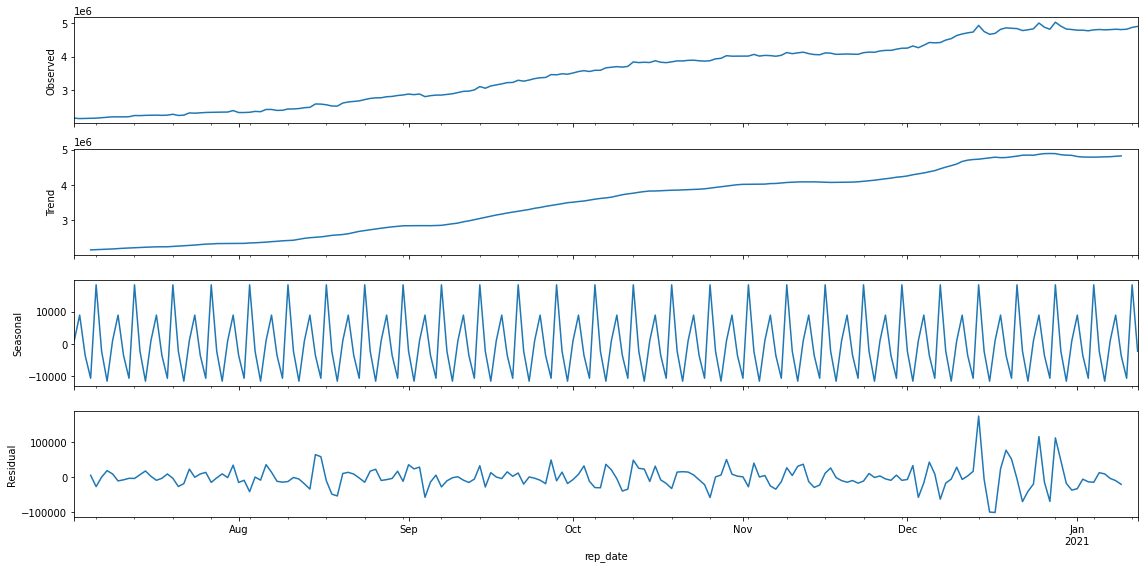

Критерий Дики-Фуллера: p=0.93842


In [8]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    

res = sm.tsa.seasonal_decompose(dts_train_hdd)
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.5f" % sm.tsa.stattools.adfuller(x=dts_train_hdd)[1])

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.701671
Критерий Дики-Фуллера: p=0.886588


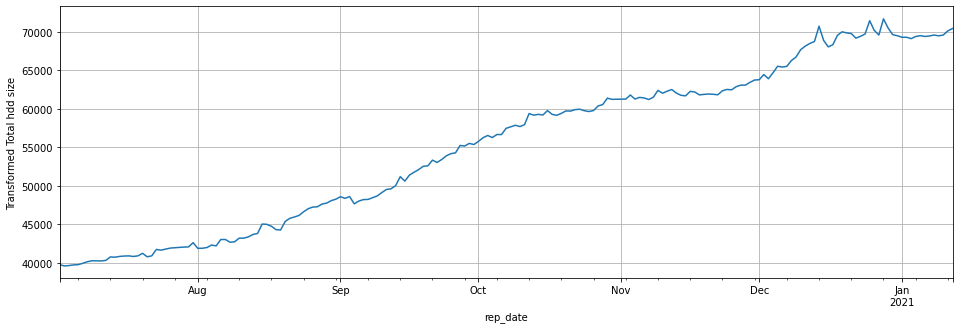

In [9]:
temp_ts, lmbda = stats.boxcox(dts_train_hdd['hdd'].copy())
dts_train_hdd = dts_train_hdd.assign(hdd_box = temp_ts)

temp_ts = stats.boxcox(dts_val_hdd['hdd'], lmbda=lmbda)
dts_val_hdd = dts_val_hdd.assign(hdd_box = temp_ts)

temp_ts = stats.boxcox(dts_test_hdd['hdd'], lmbda=lmbda)
dts_test_hdd = dts_test_hdd.assign(hdd_box = temp_ts)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dts_train_hdd['hdd_box'])[1])

plt.figure(figsize=(16,5))
dts_train_hdd['hdd_box'].plot()
plt.ylabel(u'Transformed Total hdd size')
plt.grid()
plt.show()

### Стационарность

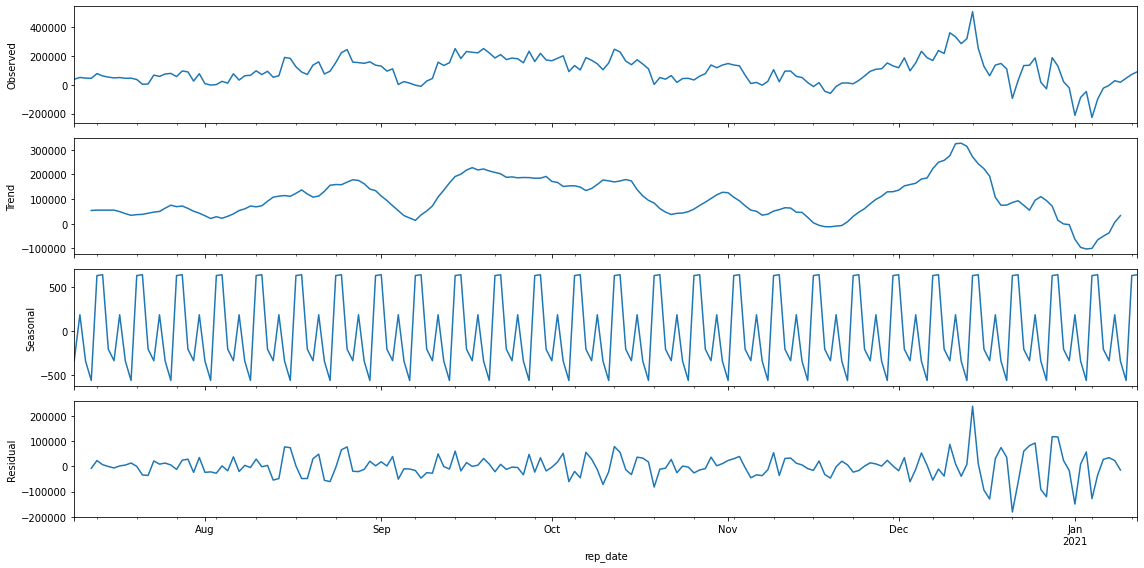

Критерий Дики-Фуллера: p=3.77e-02


In [10]:
dts_train_hdd['hdd_diff'] = dts_train_hdd['hdd'].diff(7)
dts_val_hdd['hdd_diff'] = dts_val_hdd['hdd'].diff(7)
dts_test_hdd['hdd_diff'] = dts_test_hdd['hdd'].diff(7)

res = sm.tsa.seasonal_decompose(dts_train_hdd['hdd_diff'][7:])
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.2e" % sm.tsa.stattools.adfuller(dts_train_hdd['hdd_diff'][7:])[1])

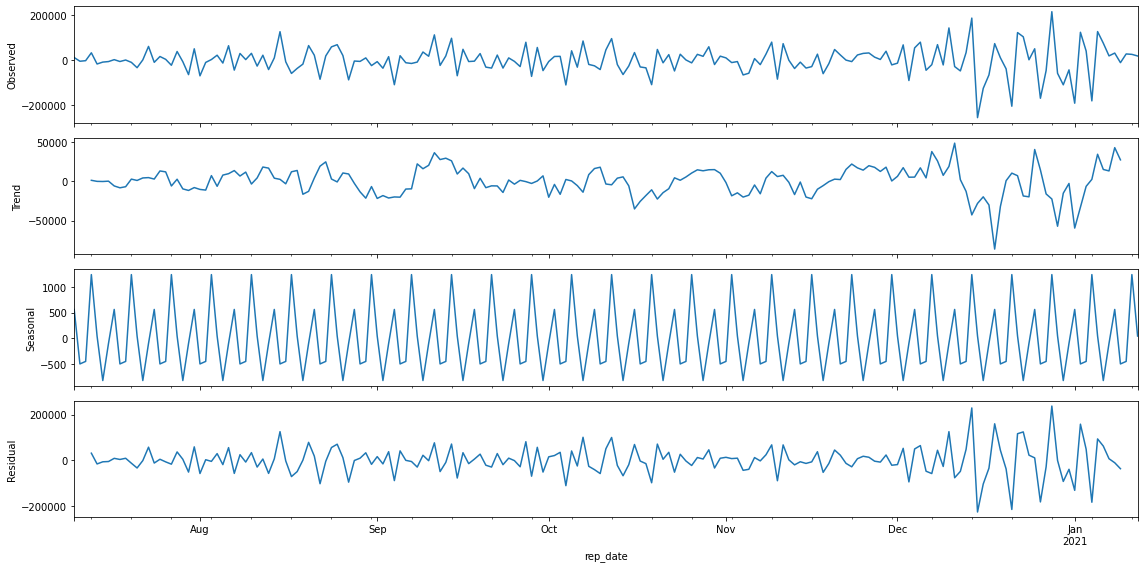

Критерий Дики-Фуллера: p=5.73e-03


In [11]:
dts_train_hdd['hdd_diff2'] = dts_train_hdd['hdd_diff'].diff(1)
dts_val_hdd['hdd_diff2'] = dts_val_hdd['hdd_diff'].diff(1)
dts_test_hdd['hdd_diff2'] = dts_test_hdd['hdd_diff'].diff(1)

res = sm.tsa.seasonal_decompose(dts_train_hdd['hdd_diff2'][8:])
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.2e" % sm.tsa.stattools.adfuller(dts_train_hdd['hdd_diff2'][8:])[1])

In [12]:
dts_train_hdd.head(10)

,hdd,hdd_box,hdd_diff,hdd_diff2
rep_date,,,,
2020-07-02,2.167869e+06,39779.699904,NaN,NaN
2020-07-03,2.154826e+06,39611.603871,NaN,NaN
2020-07-04,2.158561e+06,39659.774548,NaN,NaN
2020-07-05,2.165321e+06,39746.889330,NaN,NaN
2020-07-06,2.167468e+06,39774.539695,NaN,NaN
2020-07-07,2.181342e+06,39953.021257,NaN,NaN
2020-07-08,2.197420e+06,40159.422466,NaN,NaN
2020-07-09,2.206927e+06,40281.265560,39057.996094,NaN
2020-07-10,2.206038e+06,40269.875315,51212.062500,12154.066406


### Подбор модели

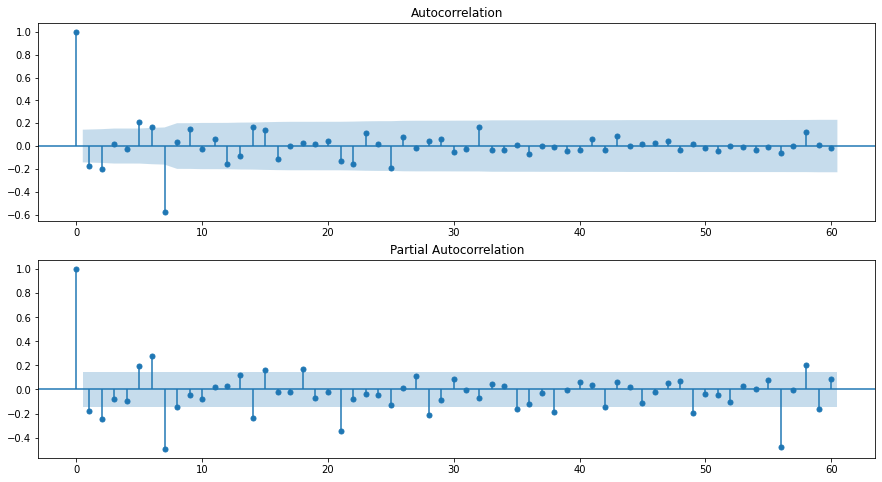

In [13]:
plt.figure(figsize=(15,8))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(dts_train_hdd['hdd_diff2'][8:].values.squeeze(), lags=60, ax=ax)
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(dts_train_hdd['hdd_diff2'][8:].values.squeeze(), lags=60, ax=ax)
plt.show()

In [14]:
p, d, q = 6, 1, 6
P, D, Q = 8, 1, 1
S = 7

In [15]:
ps = np.arange(p+1)
qs = np.arange(q+1)
Ps = np.arange(P+1)
Qs = np.arange(Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

882

In [16]:
warnings.filterwarnings('ignore')

all_results_hdd = []
best_aic_hdd = float("inf")
best_model_hdd = None
best_param_hdd = None
    
def sarimax_fit(param):
    global all_results_hdd, best_aic_hdd, best_model_hdd, best_param_hdd
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(dts_train_hdd['hdd'], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('Error!\nwrong parameters:', param)
        return 1
    
    # Результаты модели
    aic = model.aic # The Akaike information criterion
    mse_train = model.mse
    mae_train = model.mae
    mape_train = mean_absolute_percentage_error(dts_train_hdd['hdd'], model.predict())
    R2_train = r2_score(dts_train_hdd['hdd'], model.predict())
    forecast_val = model.get_forecast(dts_val_hdd.index[-1]).summary_frame()
    mse_val = mean_squared_error(dts_val_hdd['hdd'], forecast_val['mean'])
    mae_val = mean_absolute_error(dts_val_hdd['hdd'], forecast_val['mean'])
    mape_val = mean_absolute_percentage_error(dts_val_hdd['hdd'], forecast_val['mean'])
    R2_val = r2_score(dts_val_hdd['hdd'], forecast_val['mean'])
    all_results_hdd.append([param, aic, 
                            mse_train, mae_train, mape_train, R2_train, 
                            mse_val, mae_val, mape_val, R2_val])
    
    #сохраняем лучшую модель и ее параметры критерию aic
    if aic < best_aic_hdd:
        best_model_hdd = model
        best_aic_hdd = aic
        best_param_hdd = {'order':(param[0], d, param[1]), 'seasonal_order':(param[2], D, param[3], S)}
    return 0
    
# with ThreadPoolExecutor(max_workers=4) as pool:
#     pool.map(sarimax_fit, parameters_list[:100])

for param in tqdm(parameters_list):
    sarimax_fit(param)
    
# warnings.filterwarnings('DeprecationWarning')

  0%|          | 0/882 [00:00<?, ?it/s]

In [17]:
result_table = pd.DataFrame(all_results_hdd)
result_table.columns = ['Parameters', 'AIC', 'MSE_train', 'MAE_train', 'MAPE_train', 'R2_train',
                        'MSE_val', 'MAE_val', 'MAPE_val', 'R2_val']
display(result_table.sort_values(by = 'AIC', ascending=True).head())

,Parameters,AIC,MSE_train,MAE_train,MAPE_train,R2_train,MSE_val,MAE_val,MAPE_val,R2_val
3,"(0, 0, 1, 1)",4633.232337,4.397682e+10,59109.461585,0.020068,0.946292,3.764949e+10,168607.351455,0.030691,0.428873
21,"(0, 1, 1, 1)",4635.951456,4.341039e+10,58851.297807,0.020090,0.946983,7.738250e+10,261138.855887,0.047118,-0.173859
255,"(2, 0, 1, 1)",4636.157992,4.345032e+10,59242.633263,0.020293,0.946935,7.634312e+10,259340.278188,0.046805,-0.158092
165,"(1, 2, 1, 1)",4636.162544,4.345312e+10,58963.759252,0.020164,0.946931,7.675509e+10,259968.777213,0.046905,-0.164342
129,"(1, 0, 1, 1)",4636.206559,4.340589e+10,58812.100253,0.020069,0.946989,7.764626e+10,261602.383414,0.047200,-0.177860


In [18]:
print(best_model_hdd.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 hdd   No. Observations:                  195
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -2313.616
Date:                             Thu, 15 Apr 2021   AIC                           4633.232
Time:                                     15:53:45   BIC                           4642.926
Sample:                                 07-02-2020   HQIC                          4637.160
                                      - 01-12-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.6782      0.035     19.493      0.000       0.610       0.746
ma.S.L7       -1.0000      

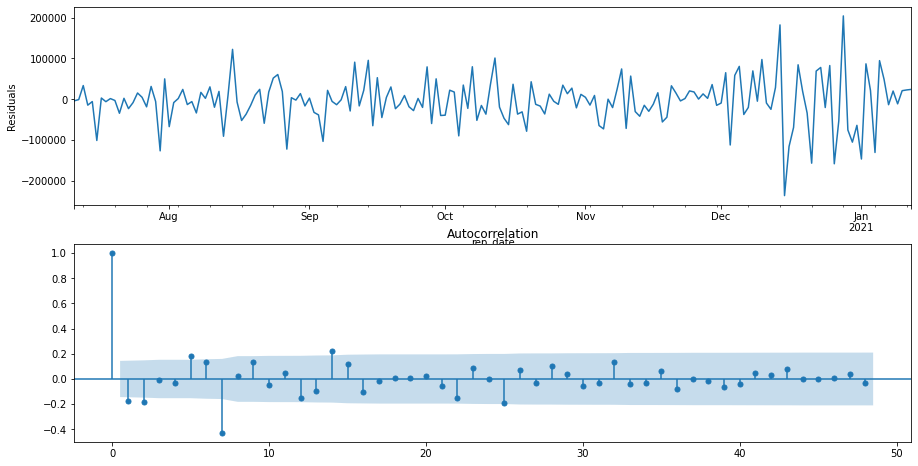

In [19]:
plt.subplots(2,1,figsize=(15,8))
plt.subplot(2,1,1)
best_model_hdd.resid[9:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model_hdd.resid[9:].values.squeeze(), lags=48, ax=ax)
plt.show()

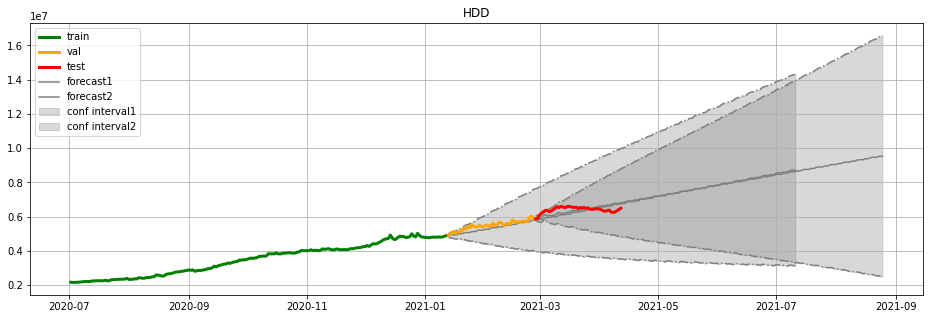

In [20]:
fig, ax = plt.subplots(figsize=(16,5))
plt.title('HDD')
plt.plot(dts_train_hdd.index, dts_train_hdd['hdd'].values, label='train', c='g', lw=3, zorder=3)
plt.plot(dts_val_hdd.index, dts_val_hdd['hdd'].values, label='val', c='orange', lw=3, zorder=3)
plt.plot(dts_test_hdd.index, dts_test_hdd['hdd'].values, label='test', c='r', lw=3, zorder=3)


model1=sm.tsa.statespace.SARIMAX(dts_train_hdd['hdd'], **best_param_hdd).fit(disp=-1)
future = dts_train_hdd.index[-1] + datetime.timedelta(days=180)
res_df = model1.get_forecast(future).summary_frame()

plt.plot(res_df.index, res_df['mean'], label='forecast1', c='grey', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_lower'], label=None, c='grey', ls='-.', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_upper'], label=None, c='grey', ls='-.', zorder=2)
plt.fill_between(res_df.index, res_df['mean_ci_lower'], res_df['mean_ci_upper'], 
                 label='conf interval1', color='grey', alpha=0.3)


model2=sm.tsa.statespace.SARIMAX(pd.concat([dts_train_hdd, dts_val_hdd])['hdd'], **best_param_hdd).fit(disp=-1)
future = pd.concat([dts_train_hdd, dts_val_hdd]).index[-1] + datetime.timedelta(days=180)
res_df = model2.get_forecast(future).summary_frame()

plt.plot(res_df.index, res_df['mean'], label='forecast2', c='grey', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_lower'], label=None, c='grey', ls='-.', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_upper'], label=None, c='grey', ls='-.', zorder=2)
plt.fill_between(res_df.index, res_df['mean_ci_lower'], res_df['mean_ci_upper'], 
                 label='conf interval2', color='grey', alpha=0.3)

plt.grid()
plt.legend()
plt.show()

## Sarimax (SSD)

### Data split

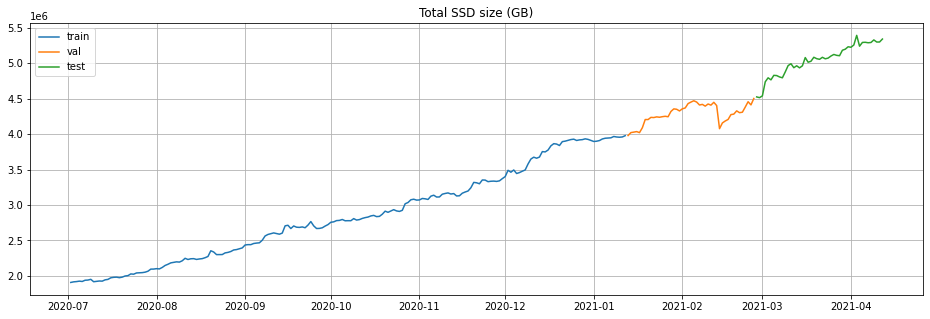

In [21]:
df_ts_ssd = df[df['disk_type_sh']=='ssd'].set_index('rep_date')[['trg.disk_size_GB']]
df_ts_ssd.columns = ['ssd']

dts_train_ssd = df_ts_ssd[:195]
dts_val_ssd = df_ts_ssd[195:240]
dts_test_ssd = df_ts_ssd[240:]

fig, ax = plt.subplots(figsize=(16,5))
plt.title('Total SSD size (GB)')
plt.plot(dts_train_ssd.index, dts_train_ssd.values, label='train')
plt.plot(dts_val_ssd.index, dts_val_ssd.values, label='val')
plt.plot(dts_test_ssd.index, dts_test_ssd.values, label='test')
plt.grid()
plt.legend()
plt.show()

### Декомпозия временного ряда

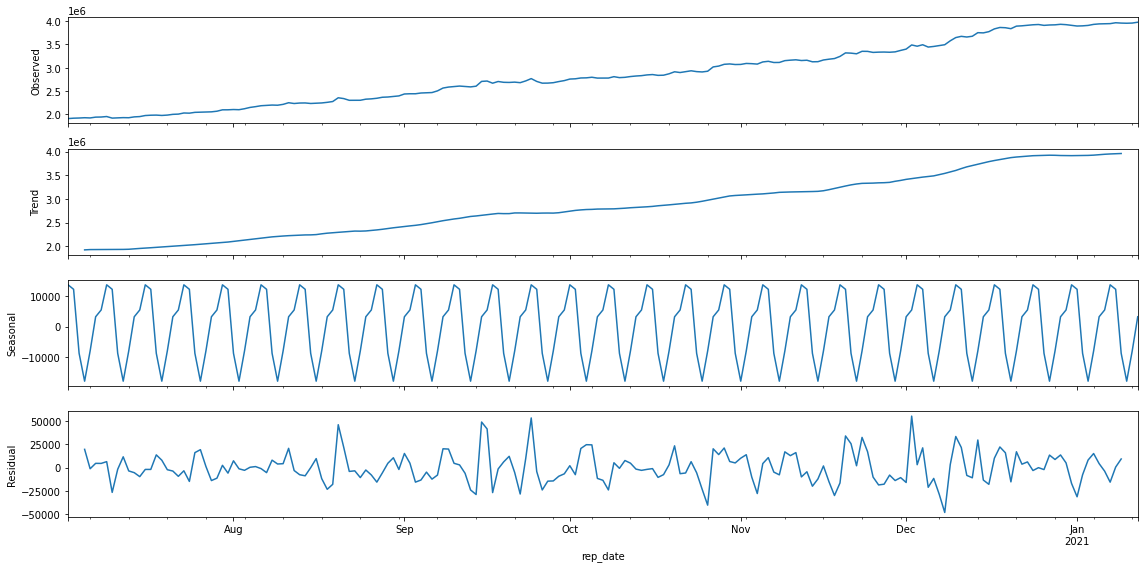

Критерий Дики-Фуллера: p=0.98642


In [22]:
def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    

res = sm.tsa.seasonal_decompose(dts_train_ssd)
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.5f" % sm.tsa.stattools.adfuller(x=dts_train_ssd)[1])

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.081867
Критерий Дики-Фуллера: p=0.892145


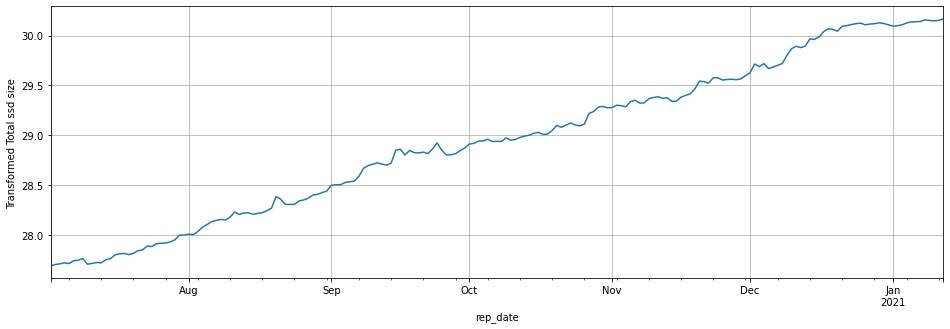

In [23]:
temp_ts, lmbda = stats.boxcox(dts_train_ssd['ssd'].copy())
dts_train_ssd = dts_train_ssd.assign(ssd_box = temp_ts)

temp_ts = stats.boxcox(dts_val_ssd['ssd'], lmbda=lmbda)
dts_val_ssd = dts_val_ssd.assign(ssd_box = temp_ts)

temp_ts = stats.boxcox(dts_test_ssd['ssd'], lmbda=lmbda)
dts_test_ssd = dts_test_ssd.assign(ssd_box = temp_ts)

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dts_train_ssd['ssd_box'])[1])

plt.figure(figsize=(16,5))
dts_train_ssd['ssd_box'].plot()
plt.ylabel(u'Transformed Total ssd size')
plt.grid()
plt.show()

### Стационарность

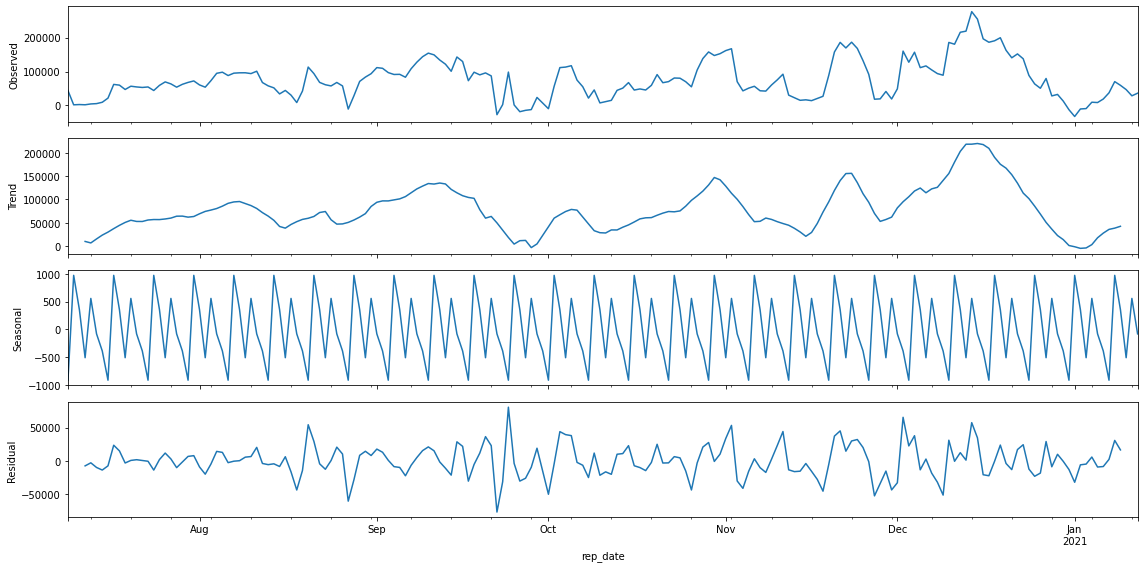

Критерий Дики-Фуллера: p=1.95e-02


In [24]:
dts_train_ssd['ssd_diff'] = dts_train_ssd['ssd'].diff(7)
dts_val_ssd['ssd_diff'] = dts_val_ssd['ssd'].diff(7)
dts_test_ssd['ssd_diff'] = dts_test_ssd['ssd'].diff(7)

res = sm.tsa.seasonal_decompose(dts_train_ssd['ssd_diff'][7:])
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.2e" % sm.tsa.stattools.adfuller(dts_train_ssd['ssd_diff'][7:])[1])

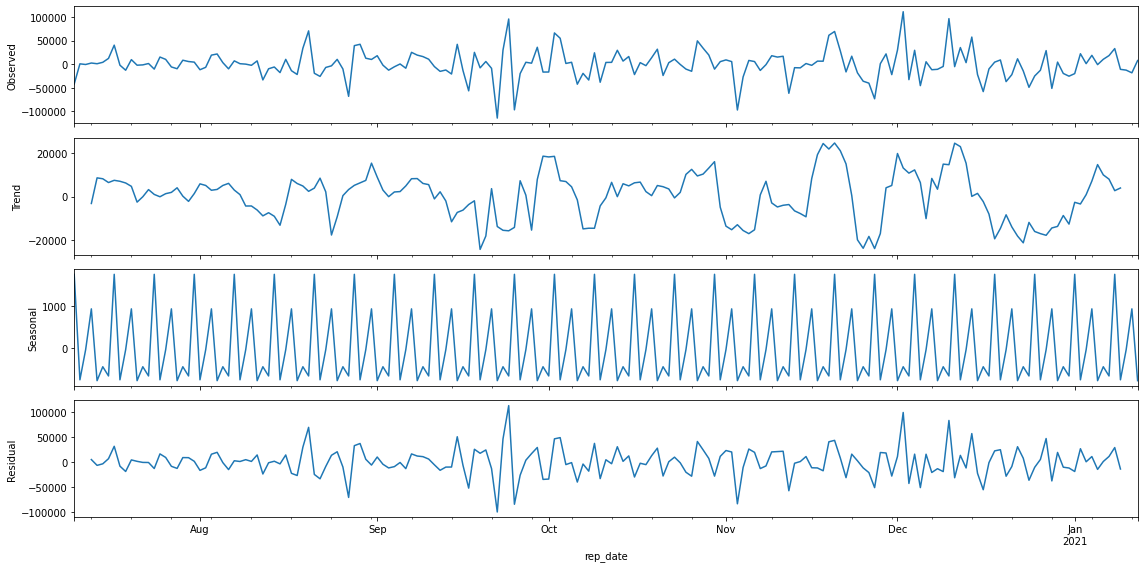

Критерий Дики-Фуллера: p=5.64e-04


In [25]:
dts_train_ssd['ssd_diff2'] = dts_train_ssd['ssd_diff'].diff(1)
dts_val_ssd['ssd_diff2'] = dts_val_ssd['ssd_diff'].diff(1)
dts_test_ssd['ssd_diff2'] = dts_test_ssd['ssd_diff'].diff(1)

res = sm.tsa.seasonal_decompose(dts_train_ssd['ssd_diff2'][8:])
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(16,8))
plotseasonal(res, axes)
plt.tight_layout()
plt.show()

print("Критерий Дики-Фуллера: p=%.2e" % sm.tsa.stattools.adfuller(dts_train_ssd['ssd_diff2'][8:])[1])

In [26]:
dts_train_ssd.head(10)

,ssd,ssd_box,ssd_diff,ssd_diff2
rep_date,,,,
2020-07-02,1.907561e+06,27.692696,NaN,NaN
2020-07-03,1.915904e+06,27.706956,NaN,NaN
2020-07-04,1.919691e+06,27.713411,NaN,NaN
2020-07-05,1.925924e+06,27.724008,NaN,NaN
2020-07-06,1.921329e+06,27.716199,NaN,NaN
2020-07-07,1.938577e+06,27.745425,NaN,NaN
2020-07-08,1.941111e+06,27.749699,NaN,NaN
2020-07-09,1.951521e+06,27.767202,43960.0,NaN
2020-07-10,1.917806e+06,27.710200,1902.5,-42057.5


### Подбор модели

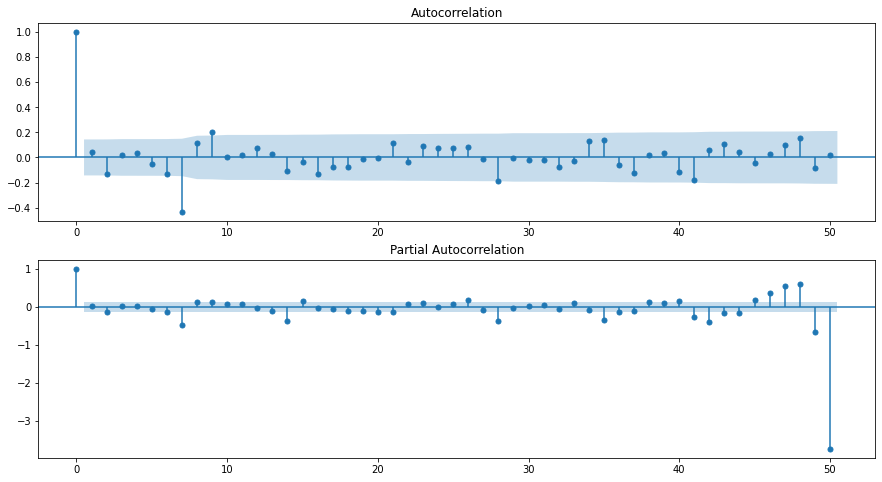

In [27]:
plt.figure(figsize=(15,8))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(dts_train_ssd['ssd_diff2'][8:].values.squeeze(), lags=50, ax=ax)
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(dts_train_ssd['ssd_diff2'][8:].values.squeeze(), lags=50, ax=ax)
plt.show()

In [28]:
p, d, q = 6, 1, 6
P, D, Q = 7, 1, 1
S = 7

In [29]:
ps = np.arange(p+1)
qs = np.arange(q+1)
Ps = np.arange(P+1)
Qs = np.arange(Q+1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

784

In [30]:
warnings.filterwarnings('ignore')

all_results_ssd = []
best_aic_ssd = float("inf")
best_model_ssd = None
best_param_ssd = None
    
def sarimax_fit(param):
    global all_results_ssd, best_aic_ssd, best_model_ssd, best_param_ssd
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(dts_train_ssd['ssd'], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except:
        print('Error!\nwrong parameters:', param)
        return 1
    
    # Результаты модели
    aic = model.aic # The Akaike information criterion
    mse_train = model.mse
    mae_train = model.mae
    mape_train = mean_absolute_percentage_error(dts_train_ssd['ssd'], model.predict())
    R2_train = r2_score(dts_train_ssd['ssd'], model.predict())
    forecast_val = model.get_forecast(dts_val_ssd.index[-1]).summary_frame()
    mse_val = mean_squared_error(dts_val_ssd['ssd'], forecast_val['mean'])
    mae_val = mean_absolute_error(dts_val_ssd['ssd'], forecast_val['mean'])
    mape_val = mean_absolute_percentage_error(dts_val_ssd['ssd'], forecast_val['mean'])
    R2_val = r2_score(dts_val_ssd['ssd'], forecast_val['mean'])
    all_results_ssd.append([param, aic, 
                            mse_train, mae_train, mape_train, R2_train, 
                            mse_val, mae_val, mape_val, R2_val])
    
    #сохраняем лучшую модель и ее параметры критерию aic
    if aic < best_aic_ssd:
        best_model_ssd = model
        best_aic_ssd = aic
        best_param_ssd = {'order':(param[0], d, param[1]), 'seasonal_order':(param[2], D, param[3], S)}
    return 0
    
# with ThreadPoolExecutor(max_workers=4) as pool:
#     pool.map(sarimax_fit, parameters_list[:100])

for param in tqdm(parameters_list):
    sarimax_fit(param)
    
# warnings.filterwarnings('DeprecationWarning')

  0%|          | 0/784 [00:00<?, ?it/s]

In [31]:
result_table = pd.DataFrame(all_results_ssd)
result_table.columns = ['Parameters', 'AIC', 'MSE_train', 'MAE_train', 'MAPE_train', 'R2_train',
                        'MSE_val', 'MAE_val', 'MAPE_val', 'R2_val']
display(result_table.sort_values(by = 'AIC', ascending=True).head())

,Parameters,AIC,MSE_train,MAE_train,MAPE_train,R2_train,MSE_val,MAE_val,MAPE_val,R2_val
3,"(0, 0, 1, 1)",4379.340095,3.454607e+10,38123.736389,0.016507,0.915681,2.460030e+10,138777.504129,0.032158,-0.284445
115,"(1, 0, 1, 1)",4380.402806,3.447724e+10,38137.007935,0.016514,0.915849,2.746567e+10,142011.456582,0.032824,-0.434054
19,"(0, 1, 1, 1)",4380.697479,3.447079e+10,38138.627048,0.016515,0.915865,2.762727e+10,142311.979730,0.032890,-0.442491
227,"(2, 0, 1, 1)",4381.958482,3.447705e+10,38225.517709,0.016564,0.915849,2.715506e+10,141405.451074,0.032693,-0.417836
117,"(1, 0, 2, 1)",4382.354987,3.448139e+10,38130.223964,0.016512,0.915839,2.738434e+10,141827.922854,0.032782,-0.429807


In [32]:
print(best_model_ssd.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 ssd   No. Observations:                  195
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 7)   Log Likelihood               -2186.670
Date:                             Thu, 15 Apr 2021   AIC                           4379.340
Time:                                     16:54:38   BIC                           4389.033
Sample:                                 07-02-2020   HQIC                          4383.268
                                      - 01-12-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.8110      0.025     32.139      0.000       0.762       0.860
ma.S.L7       -0.9998      

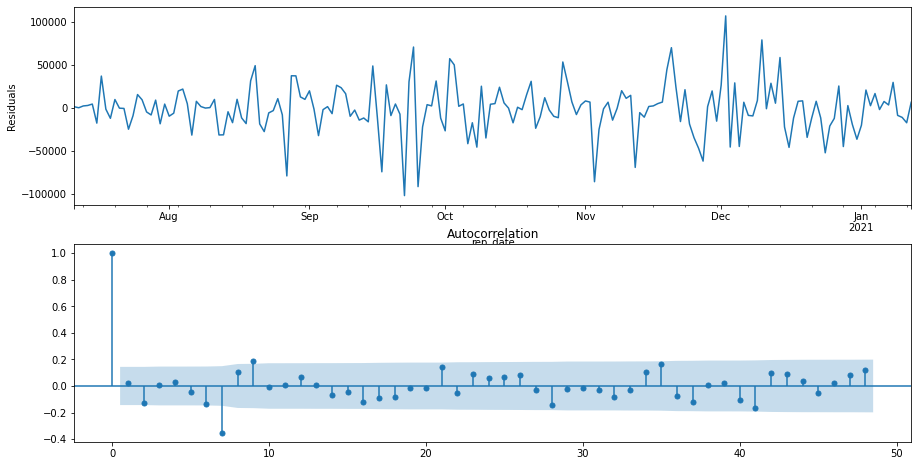

In [33]:
plt.subplots(2,1,figsize=(15,8))
plt.subplot(2,1,1)
best_model_ssd.resid[9:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model_ssd.resid[9:].values.squeeze(), lags=48, ax=ax)
plt.show()

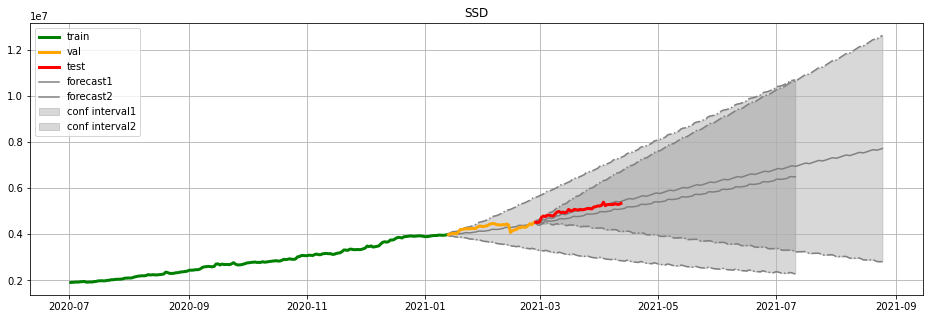

In [41]:
fig, ax = plt.subplots(figsize=(16,5))
plt.title('SSD')
plt.plot(dts_train_ssd.index, dts_train_ssd['ssd'].values, label='train', c='g', lw=3, zorder=3)
plt.plot(dts_val_ssd.index, dts_val_ssd['ssd'].values, label='val', c='orange', lw=3, zorder=3)
plt.plot(dts_test_ssd.index, dts_test_ssd['ssd'].values, label='test', c='r', lw=3, zorder=3)


model1=sm.tsa.statespace.SARIMAX(dts_train_ssd['ssd'], **best_param_ssd).fit(disp=-1)
future = dts_train_ssd.index[-1] + datetime.timedelta(days=180)
res_df = model1.get_forecast(future).summary_frame()

plt.plot(res_df.index, res_df['mean'], label='forecast1', c='grey', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_lower'], label=None, c='grey', ls='-.', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_upper'], label=None, c='grey', ls='-.', zorder=2)
plt.fill_between(res_df.index, res_df['mean_ci_lower'], res_df['mean_ci_upper'], 
                 label='conf interval1', color='grey', alpha=0.3)


model2=sm.tsa.statespace.SARIMAX(pd.concat([dts_train_ssd, dts_val_ssd])['ssd'], **best_param_ssd).fit(disp=-1)
future = pd.concat([dts_train_ssd, dts_val_ssd]).index[-1] + datetime.timedelta(days=180)
res_df = model2.get_forecast(future).summary_frame()

plt.plot(res_df.index, res_df['mean'], label='forecast2', c='grey', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_lower'], label=None, c='grey', ls='-.', zorder=2)
plt.plot(res_df.index, res_df['mean_ci_upper'], label=None, c='grey', ls='-.', zorder=2)
plt.fill_between(res_df.index, res_df['mean_ci_lower'], res_df['mean_ci_upper'], 
                 label='conf interval2', color='grey', alpha=0.3)

plt.grid()
plt.legend()
plt.show()